## Imports & Loading the data

In [3]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [4]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [5]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

In [6]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [7]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [8]:
sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = pickle.load(open('train_w_lags.pickle', 'rb'))

In [9]:
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [10]:
sj_train_test = fill_from_train(sj_train_test, sj_train_train)
iq_train_test = fill_from_train(iq_train_test, iq_train_train)

/tmp/ipykernel_2465992/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


# San Juan

## Extracting the seasonality 

<AxesSubplot:xlabel='weekofyear'>

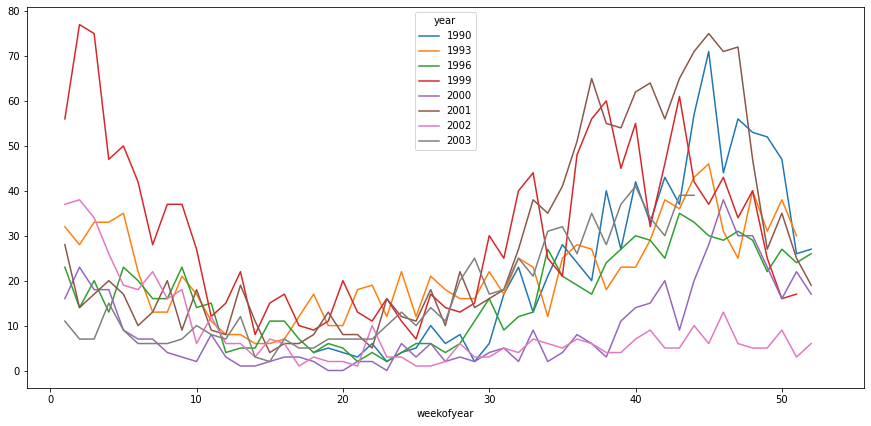

In [11]:
(
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .T
#     .lt(100)
#     .any()
    .loc[:,lambda df: df.max(axis=0) < 100]
    .plot()
)

In [12]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [13]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', cutoff=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


## Evaluating the saisonality as a baseline model

In [14]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [15]:
# seasonality_for_test(sj_train_test, sj_train_train_seas)

In [16]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 27.5
--------------------
MAE: 18.12
Explained variance: 0.076
--------------------


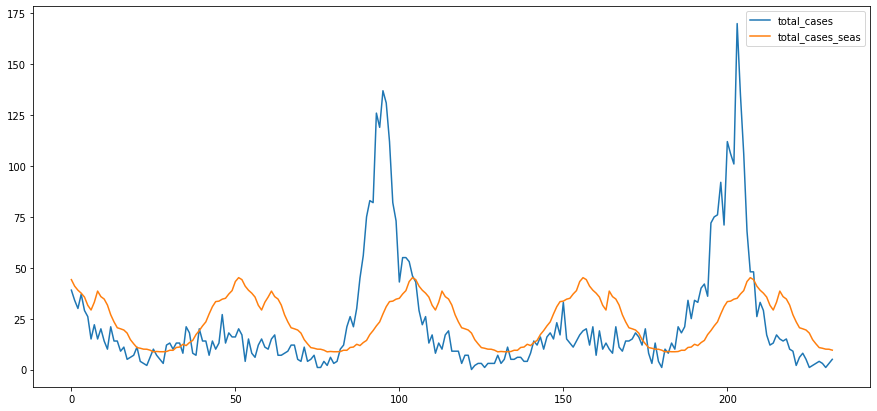

In [17]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

## Substracting the saisonality

In [18]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [19]:
sj_train_train = substract_seas(sj_train_train, 'total_cases', sj_train_train_seas)
sj_train_test = substract_seas(sj_train_test, 'total_cases', sj_train_train_seas)

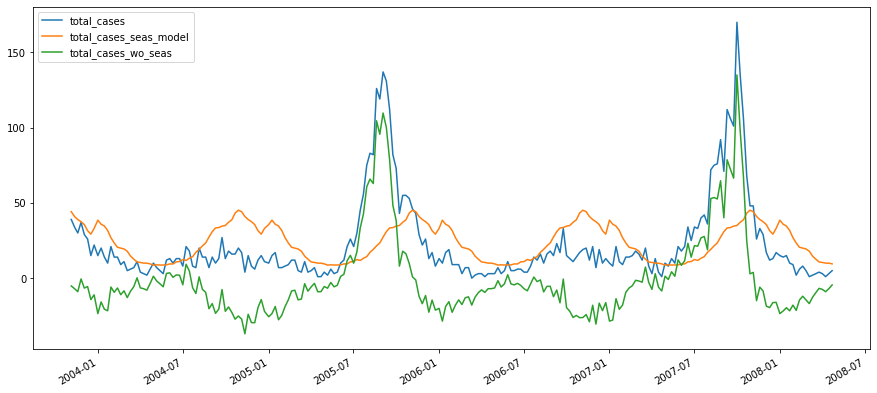

In [20]:
(
    sj_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

# Regression (Random Forest)

## Preprocessing for Sklearn

In [21]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_seas_model',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [22]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

## Feature selection

In [123]:
# Using the Pearson correlation coefficients and a selection of the strongest
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases_wo_seas']
    .drop(['total_cases_wo_seas', 'total_cases_seas_model', 'total_cases'])
    .abs()
    .sort_values()
#     .tail(100)
    .index
)

In [124]:
# my_features

In [125]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [126]:
def reduce_features_lda_border(df, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=1)
    lda_comps = lda.fit_transform(df_scaled.dropna(), 
                                  np.where(custom_dropper(df, cols)[target] > border, 1, 0).tolist())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[my_features].dropna().index
    return lda_df

In [127]:
def reduce_features_lda_bins(df, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda_comps = lda.fit_transform(df_scaled.dropna(), 
                                  pd.cut(custom_dropper(df, cols)[target], n_bins, labels=False))
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[my_features].dropna().index
    return lda_df

In [128]:
# X_train = sj_train_train[my_features].dropna()
# X_test = sj_train_test[my_features].dropna()

# X_train = reduce_features_pca(sj_train_train, my_features, n_pc=3)
# X_test = reduce_features_pca(sj_train_test, my_features, n_pc=3)

X_train = reduce_features_lda_border(sj_train_train, my_features, target='total_cases_wo_seas', border=80)
X_test = reduce_features_lda_border(sj_train_test, my_features, target='total_cases_wo_seas', border=80)

# X_train = reduce_features_lda_bins(sj_train_train, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)
# X_test = reduce_features_lda_bins(sj_train_test, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)

y_train = custom_dropper(sj_train_train, my_features).total_cases_wo_seas
y_test = custom_dropper(sj_train_test, my_features).total_cases_wo_seas


## Scaling

In [129]:
from sklearn.preprocessing import StandardScaler

In [130]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Regression (Random Forest)

In [131]:
from sklearn.ensemble import RandomForestRegressor

In [132]:
from sklearn.model_selection import GridSearchCV

In [133]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [3, 5, 10, 20],
    'max_depth': [1, 2, 3],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [10, 15, 20, 30, 50],
#     'bootstrap': [True, False],
    'min_samples_split': [5, 7, 10]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)

In [134]:
# rf = gs.best_estimator_

In [135]:
rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=20,
#                            min_samples_split= 5,
                           max_leaf_nodes= 43,
)

In [136]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_leaf_nodes=43)

In [137]:
y_train_pred = rf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [138]:
y_train = y_train + custom_dropper(sj_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(sj_train_train, my_features).total_cases_seas_model

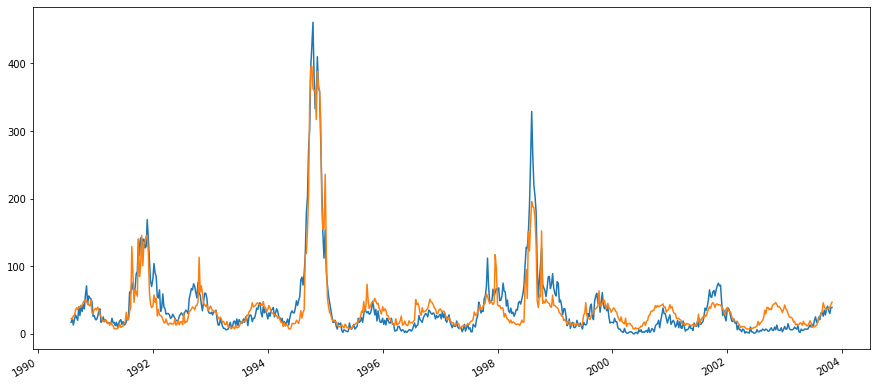

In [139]:
y_train.plot()
y_train_pred.plot();

In [140]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 20.04
--------------------
MAE: 14.26
Explained variance: 0.875
--------------------


In [141]:
y_test_pred = rf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [142]:
y_test = y_test + custom_dropper(sj_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(sj_train_test, my_features).total_cases_seas_model

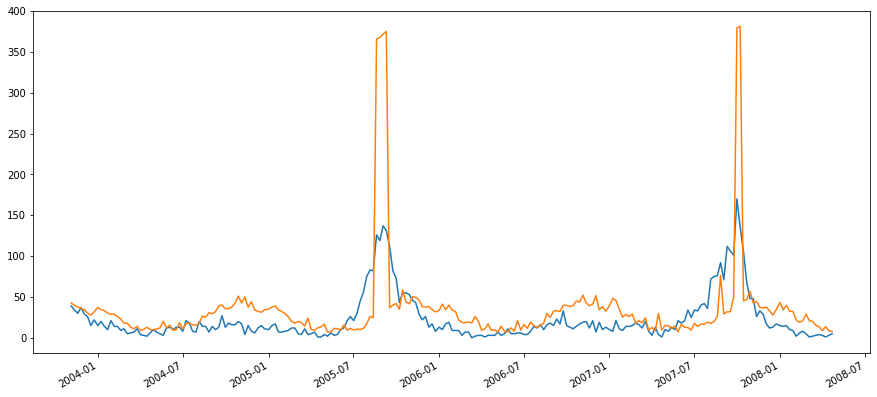

In [143]:
y_test.plot()
y_test_pred.plot();

In [144]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 43.76
--------------------
MAE: 22.37
Explained variance: -1.16
--------------------


## Smoothing

In [145]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

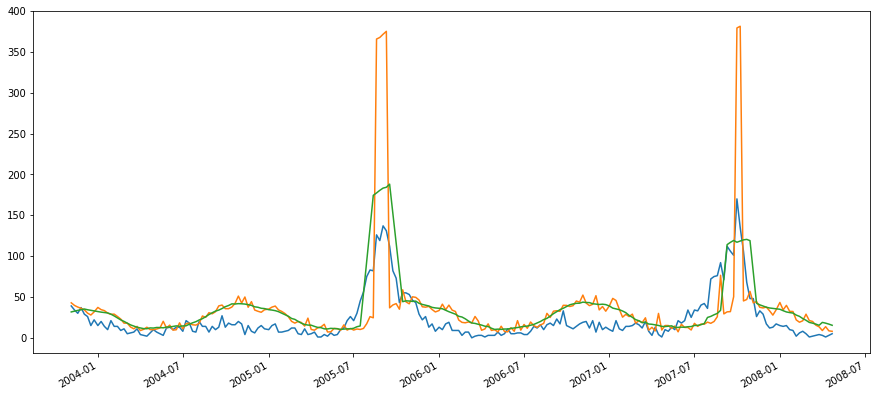

In [146]:
y_test.plot()
y_test_pred.plot();
lossless_centered_smoothing(y_test_pred, y_train, w=9).plot();

In [149]:
model_classification(y_test, lossless_centered_smoothing(y_test_pred, y_train, w=9))

--------------------
RMSE: 22.1
--------------------
MAE: 17.01
Explained variance: 0.587
--------------------


# Iquitos

## Extracting the seasonality 

<AxesSubplot:xlabel='weekofyear'>

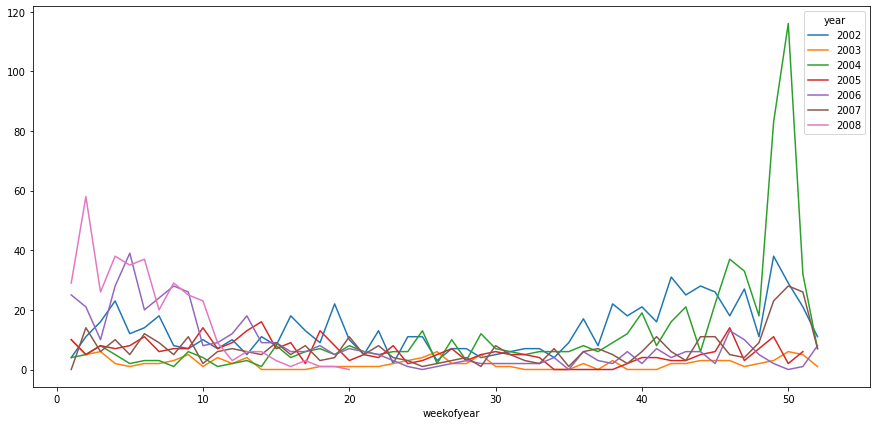

In [47]:
(
    iq_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .loc[:,lambda df: df.max(axis=0) < 100]
    .plot()
)

In [48]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [49]:
iq_train_train_seas = get_smooth_seasonality_df(iq_train_train, 'total_cases', cutoff=60)
iq_train_train_seas.head()

,weekofyear,total_cases
0,1,13.666667
1,2,14.666667
2,3,16.333333
3,4,15.555556
4,5,16.888889


## Evaluating the saisonality as a baseline model

In [50]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [51]:
# seasonality_for_test(iq_train_test, iq_train_train_seas)

In [52]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 10.43
--------------------
MAE: 6.01
Explained variance: 0.156
--------------------


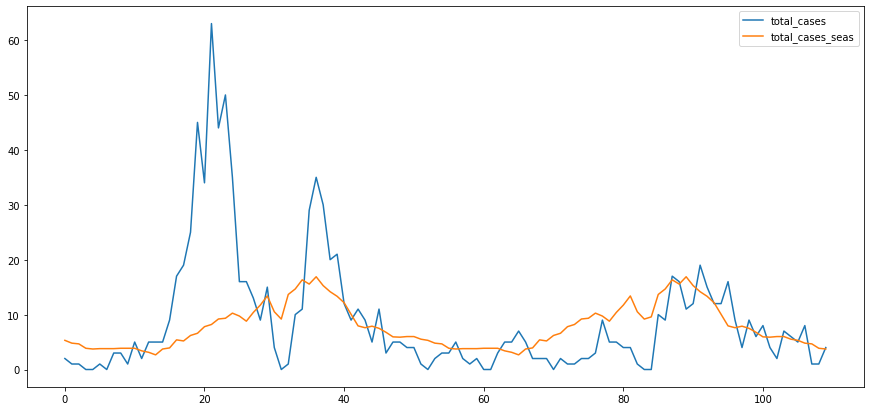

In [53]:
seasonality_baseline_eval(iq_train_test, iq_train_train_seas)

## Substracting the saisonality

In [54]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [55]:
iq_train_train = substract_seas(iq_train_train, 'total_cases', iq_train_train_seas)
iq_train_test = substract_seas(iq_train_test, 'total_cases', iq_train_train_seas)

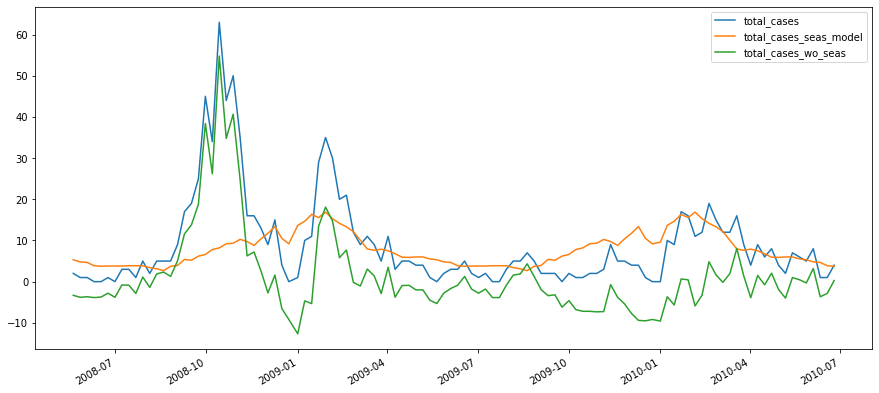

In [56]:
(
    iq_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

# Regression (Random Forest)

## Preprocessing for Sklearn

## Feature selection

In [57]:
# Using the Pearson correlation coefficients and a selection of the strongest
corr_mat = iq_train_train.corr()
my_features = (
    corr_mat['total_cases_wo_seas']
    .drop(['total_cases_wo_seas', 'total_cases_seas_model', 'total_cases'])
    .abs()
    .sort_values()
#     .tail(100)
    .index
)

In [58]:
# my_features

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [61]:
# X_train = iq_train_train[my_features].dropna()
# X_test = iq_train_test[my_features].dropna()

# X_train = reduce_features_pca(iq_train_train, my_features, n_pc=3)
# X_test = reduce_features_pca(iq_train_test, my_features, n_pc=3)

X_train = reduce_features_lda_border(iq_train_train, my_features, target='total_cases_wo_seas', border=40)
X_test = reduce_features_lda_border(iq_train_test, my_features, target='total_cases_wo_seas', border=40)

# X_train = reduce_features_lda_bins(iq_train_train, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)
# X_test = reduce_features_lda_bins(iq_train_test, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)

y_train = custom_dropper(iq_train_train, my_features).total_cases_wo_seas
y_test = custom_dropper(iq_train_test, my_features).total_cases_wo_seas


## Scaling

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Regression (Random Forest)

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [3, 5, 10, 20],
    'max_depth': [1, 2, 3],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [10, 15, 20, 30, 50],
#     'bootstrap': [True, False],
    'min_samples_split': [5, 7, 10]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)

In [67]:
# rf = gs.best_estimator_

In [68]:
rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=20,
#                            min_samples_split= 5,
#                            max_leaf_nodes= 43,
)

In [69]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [70]:
y_train_pred = rf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [71]:
y_train = y_train + custom_dropper(iq_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(iq_train_train, my_features).total_cases_seas_model

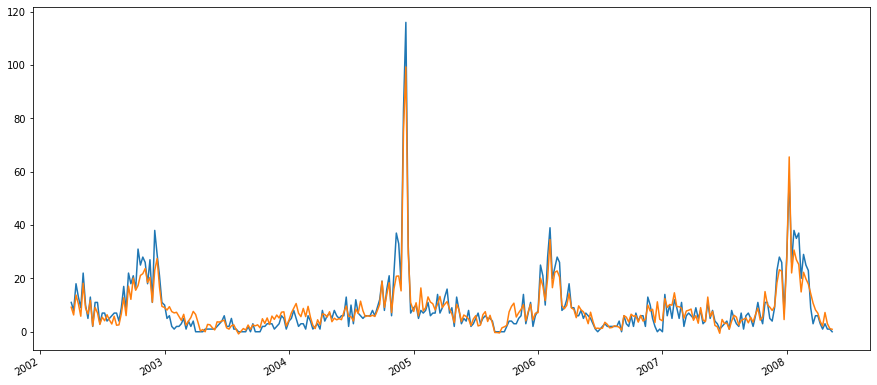

In [72]:
y_train.plot()
y_train_pred.plot();

In [73]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 3.53
--------------------
MAE: 2.49
Explained variance: 0.903
--------------------


In [74]:
y_test_pred = rf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [75]:
y_test = y_test + custom_dropper(iq_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(iq_train_test, my_features).total_cases_seas_model

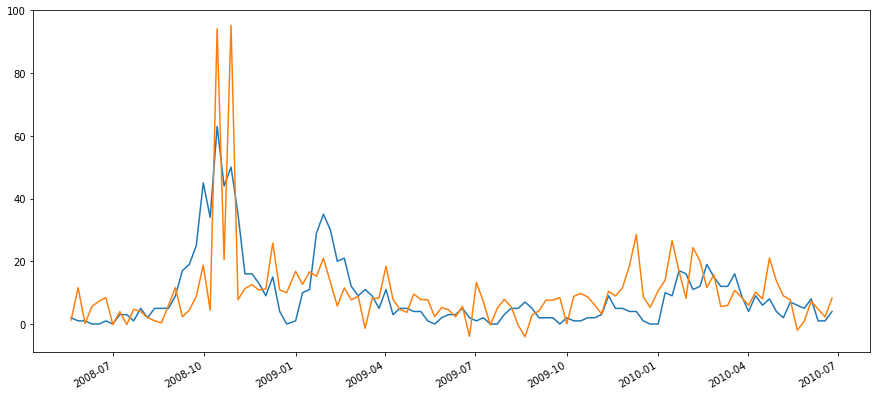

In [76]:
y_test.plot()
y_test_pred.plot();

In [77]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 10.39
--------------------
MAE: 7.16
Explained variance: 0.16
--------------------


## Smoothing

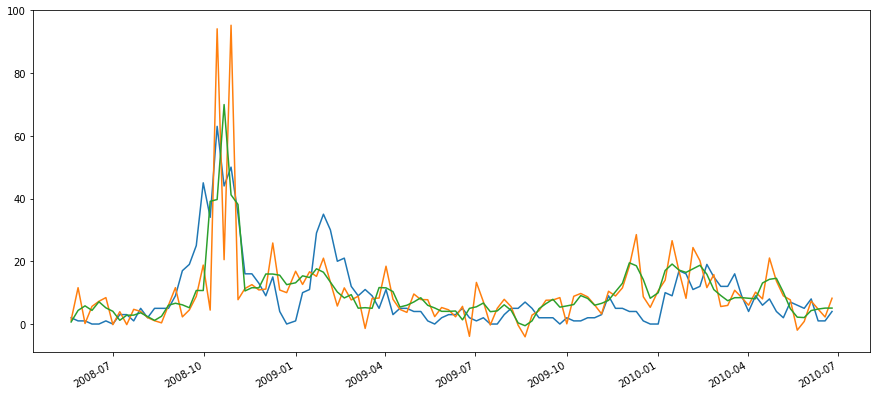

In [110]:
y_test.plot()
y_test_pred.plot();
lossless_centered_smoothing(y_test_pred, y_train, w=3).plot();

In [109]:
model_classification(y_test, lossless_centered_smoothing(y_test_pred, y_train, w=3))

--------------------
RMSE: 8.04
--------------------
MAE: 5.95
Explained variance: 0.499
--------------------
